In [108]:
import pathlib as plb
import tempfile

import dicom2nifti
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import nilearn.image
import shutil
import pydicom
from nibabel.orientations import ornt_transform, axcodes2ornt, inv_ornt_aff, apply_orientation, io_orientation, aff2axcodes


### Subroutines

In [109]:
# Nifti reorientation
def reorient_nifti(img,
                   target_orientation=('L','A','S'),
                   verbose=False):
    new_ornt = axcodes2ornt(target_orientation)
    vox_array = img.get_fdata()
    affine = img.affine
    orig_ornt = io_orientation(img.affine)
    ornt_trans = ornt_transform(orig_ornt, new_ornt)
    orig_shape = vox_array.shape
    new_vox_array = apply_orientation(vox_array, ornt_trans)
    aff_trans = inv_ornt_aff(ornt_trans, orig_shape)
    new_affine = np.dot(affine, aff_trans)
    if verbose:
        print(f'{aff2axcodes(affine)} -> {aff2axcodes(new_affine)}')
    new_img = nib.Nifti1Image(new_vox_array, new_affine, img.header)
    return new_img

In [110]:
# SUV conversion
def conv_time(time_str):
    return (float(time_str[:2]) * 3600 + float(time_str[2:4]) * 60 + float(time_str[4:13]))

def calculate_suv_factor(dcm_path):
    ds = pydicom.dcmread(str(dcm_path))
    total_dose = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose
    start_time = ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime
    half_life = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife
    acq_time = ds.AcquisitionTime
    weight = ds.PatientWeight
    time_diff = conv_time(acq_time) - conv_time(start_time)
    act_dose = total_dose * 0.5 ** (time_diff / half_life)
    suv_factor = 1000 * weight / act_dose
    return suv_factor

def convert_pet(pet, suv_factor=1.0):
    affine = pet.affine
    pet_data = pet.get_fdata()
    pet_suv_data = (pet_data*suv_factor).astype(np.float32)
    pet_suv = nib.Nifti1Image(pet_suv_data, affine)
    return pet_suv 

In [111]:
# PET/CT resampling and alignement
def resample_nifti(ct_nii, suv_nii,
                   target_orientation, target_spacing):
    ct = nib.load(ct_nii)
    suv = nib.load(suv_nii)

    # reorient niftis
    ct = reorient_nifti(ct, target_orientation=target_orientation)
    suv = reorient_nifti(suv, target_orientation=target_orientation)

    # resample and align pet/ct
    orig_spacing = np.array(ct.header.get_zooms())
    orig_shape = ct.header.get_data_shape()
    target_affine = np.copy(ct.affine)
    target_affine[:3, :3] = np.diag(target_spacing / orig_spacing) @ ct.affine[:3, :3]
    target_shape = (orig_shape*(orig_spacing/target_spacing)).astype(int)

    ct_rs = nilearn.image.resample_img(ct, target_affine, target_shape,
                                    interpolation='continuous',
                                    fill_value=-1024)
    ct_rs.set_data_dtype(np.float32)

    suv_rs = nilearn.image.resample_to_img(suv, ct_rs,
                                            interpolation='continuous',
                                            fill_value=0)
    suv_rs.set_data_dtype(np.float32)

    nib.save(ct_rs, ct_nii.parent/('rsCT.nii.gz'))
    nib.save(suv_rs, suv_nii.parent/('rsSUV.nii.gz')) 

### Preprocessing

In [112]:
target_orientation = 'LAS'
target_spacing = [2.0, 2.0, 3.0]

In [113]:
ct_nii_pattern = '*gk*.nii.gz'
suv_nii_pattern = 'suv*.nii.gz'

In [114]:
# specify root directory containing all dicom directories (one per subject)
dicom_root = plb.Path('/mnt/data/datasets/Stanford/dicom')
dicom_dirs = list(dicom_root.glob('*'))
nifti_dir = dicom_root.parent/'nifti'
nifti_dir.mkdir(exist_ok=True)

print(f'found {len(dicom_dirs)} dicom directories')
print(dicom_dirs)

print(f'niftis will be stored in {nifti_dir}')


found 2 dicom directories
[PosixPath('/mnt/data/datasets/Stanford/dicom/out'), PosixPath('/mnt/data/datasets/Stanford/dicom/out2')]
niftis will be stored in /mnt/data/datasets/Stanford/nifti


In [115]:
for dicom_dir in dicom_dirs:
    subject = dicom_dir.name
    print(f'processing {dicom_dir}')
    for d in (dicom_dir/'FinalDicoms').glob('*'):
        first_dcm = next(d.glob('*.dcm'))
        ds = pydicom.read_file(first_dcm)
        modality = ds.Modality
        print(f'  converting {modality} ...')
        # create nifti sub-directory 
        # (dirname = subject dicom dirname)
        nii_d = nifti_dir/subject
        nii_d.mkdir(exist_ok=True)

        if modality == 'PT':
            # select sample pet dicom file to read header
            suv_corr_factor = calculate_suv_factor(first_dcm)

        with tempfile.TemporaryDirectory() as tmp:
            tmp = plb.Path(str(tmp))
            # convert dicom directory to nifti
            # (store results in temp directory)
            dicom2nifti.convert_directory(d, str(tmp), 
                                          compression=True, reorient=True)
            nii = next(tmp.glob('*nii.gz'))
            # copy niftis to output folder with consistent naming
            f = nii_d/f'{modality}.nii.gz'
            shutil.copy(nii, nii_d/f'{modality}.nii.gz')
            print(f'    -> stored as {f}')

            if modality == 'PT':
                print(f'  converting SUV ...')
                g = nii_d/'SUV.nii.gz'
                suv_pet_nii = convert_pet(nib.load(f),        suv_factor=suv_corr_factor)
                nib.save(suv_pet_nii, g)
                print(f'    -> stored as {g}')
        
    print(f'  resample and align CT/SUV ...')
    resample_nifti(nii_d/'CT.nii.gz', nii_d/'SUV.nii.gz', target_orientation, target_spacing)


        



processing /mnt/data/datasets/Stanford/dicom/out
  converting PT ...
    -> stored as /mnt/data/datasets/Stanford/nifti/out/PT.nii.gz
  converting SUV ...
    -> stored as /mnt/data/datasets/Stanford/nifti/out/SUV.nii.gz
  converting CT ...
    -> stored as /mnt/data/datasets/Stanford/nifti/out/CT.nii.gz
  resample and align CT/SUV ...
processing /mnt/data/datasets/Stanford/dicom/out2
  converting PT ...
    -> stored as /mnt/data/datasets/Stanford/nifti/out2/PT.nii.gz
  converting SUV ...
    -> stored as /mnt/data/datasets/Stanford/nifti/out2/SUV.nii.gz
  converting CT ...
    -> stored as /mnt/data/datasets/Stanford/nifti/out2/CT.nii.gz
  resample and align CT/SUV ...


### Visualization

(213, 213, 285) (213, 213, 285)


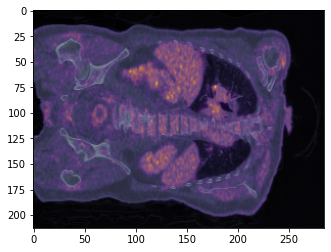

In [107]:
ct = nib.load(nii_d/'rsCT.nii.gz')
suv = nib.load(nii_d/'rsSUV.nii.gz')
slice_pos = ct.shape[2]//4
plt.imshow(ct.get_fdata()[:, slice_pos, :], cmap='bone')
plt.imshow(suv.get_fdata()[:, slice_pos, :], alpha=0.5, cmap='inferno')
print(ct.shape, suv.shape)
